In [14]:
# pip install -U tensorflow-addons

In [15]:
# !unzip Apple.zip

In [16]:
# !pip install opencv-python
# !pip install opencv-python-headless
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scikit-image
# !pip install -U scikit-image

In [17]:
import tensorflow as tf

from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

tfds.disable_progress_bar()

In [18]:
# DIR=r'/content/drive/MyDrive/DLA Project/apple_split'

In [19]:
IMG_SIZE=224

In [20]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=90,
                                brightness_range= [0.2,0.8])

datagen=ImageDataGenerator(rescale=1./255)

train_data=train_datagen.flow_from_directory('apple_split/train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=4,
                                         class_mode='categorical', shuffle= True, seed =1212)

val_data=datagen.flow_from_directory('apple_split/val',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=4,
                                         class_mode='categorical',shuffle= True, seed =1212)

test_data=datagen.flow_from_directory('apple_split/test',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=4,
                                         class_mode='categorical',shuffle= False, seed =1212)

Found 1454 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 186 images belonging to 4 classes.


In [21]:
patch_size = 4  # 2x2, for the Transformer blocks.

In [29]:
# input_shape = (224, 224, 3)
# patch_size = 2
# num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
# embedding_dim = 64 

In [35]:
def conv_block(x, filters=16, kernel_size=3, strides=1):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation="relu", padding="same"
    )
    return conv_layer(x)
#     # Depthwise convolution.
#     x1 = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
#     x2 = layers.Add()([x1, x])  # Residual.
    
#     x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

#     # Pointwise convolution.
#     x4 = layers.Conv2D(filters, kernel_size=1)(x3)
#     x5 = layers.Add()([x4, x2]) 
#     return x5

# class PatchExtract(layers.Layer):
#     def __init__(self, patch_size, **kwargs):
#         super(PatchExtract, self).__init__(**kwargs)
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=(1, self.patch_size, self.patch_size, 1),
#             strides=(1, self.patch_size, self.patch_size, 1),
#             rates=(1, 1, 1, 1),
#             padding="VALID",
#         )
#         patch_dim = patches.shape[-1]
#         patch_num = patches.shape[1]
#         return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


# class PatchEmbedding(layers.Layer):
#     def __init__(self, num_patch, embed_dim, **kwargs):
#         super(PatchEmbedding, self).__init__(**kwargs)
#         self.num_patch = num_patch
#         self.proj = layers.Dense(embed_dim)
#         self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

#     def call(self, patch):
#         pos = tf.range(start=0, limit=self.num_patch, delta=1)
#         return self.proj(patch) + self.pos_embed(pos)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])
    return x

def vit_block(x, num_blocks, projection_dim, strides=1):

    # Unfold into patches and then pass through Transformers.
    num_patches = int((x.shape[1] * x.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(x)
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim)

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*x.shape[1:-1], projection_dim))(global_features)

    return folded_feature_map

In [36]:
def ConvVit(num_classes=4):
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = layers.ZeroPadding2D(padding = (1,1))(inputs)
#      # Extract patches.
#     x = PatchExtract(patch_size)(x)
#     # Create patch embedding.
#     x = PatchEmbedding(num_patches, x.shape[-1] * 2)(x)
    

    # First Stage
    x = conv_block(x, filters=64)
    x = conv_block(x, filters=64)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Second Stage
    x = conv_block(x, filters=128)
    x = conv_block(x, filters=128)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    #Third Stage
    x = conv_block(x, filters=256)
    x = conv_block(x, filters=256)
    x = vit_block(x, num_blocks=4, projection_dim=256)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    #Fourth Stage
    x = conv_block(x, filters=512)
    x = vit_block(x, num_blocks=1, projection_dim=512)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

ConvVit_xxs = ConvVit()
ConvVit_xxs.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 226, 226, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 226, 226, 64) 1792        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 226, 226, 64) 36928       conv2d_9[0][0]                   
____________________________________________________________________________________________

In [37]:
ConvVit_xxs.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [41]:
model_history=ConvVit_xxs.fit(train_data,validation_data=val_data,epochs=50)

Epoch 1/50
364/364 [==============================] - 53s 146ms/step - loss: 1.2626 - accuracy: 0.3143 - val_loss: 1.2515 - val_accuracy: 0.3425
Epoch 2/50
364/364 [==============================] - 51s 139ms/step - loss: 1.2526 - accuracy: 0.3611 - val_loss: 1.2434 - val_accuracy: 0.3425
Epoch 3/50
364/364 [==============================] - 47s 127ms/step - loss: 1.2500 - accuracy: 0.3336 - val_loss: 1.2433 - val_accuracy: 0.3425
Epoch 4/50
364/364 [==============================] - 51s 140ms/step - loss: 1.2484 - accuracy: 0.3281 - val_loss: 1.2425 - val_accuracy: 0.3425
Epoch 5/50
364/364 [==============================] - 50s 136ms/step - loss: 1.2500 - accuracy: 0.3177 - val_loss: 1.2682 - val_accuracy: 0.3425
Epoch 6/50
364/364 [==============================] - 55s 152ms/step - loss: 1.2528 - accuracy: 0.3226 - val_loss: 1.2434 - val_accuracy: 0.3425
Epoch 7/50
364/364 [==============================] - 60s 165ms/step - loss: 1.2497 - accuracy: 0.3267 - val_loss: 1.2545 - val_ac

In [42]:
ConvVit_xxs.evaluate(test_data)

47/47 [==============================] - 3s 59ms/step - loss: 1.2501 - accuracy: 0.3387


[1.2501072883605957, 0.33870968222618103]

In [43]:
ConvVit_xxs.save('convVit_model.h5')
ConvVit_xxs.save_weights('convVit_model.h5')

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2


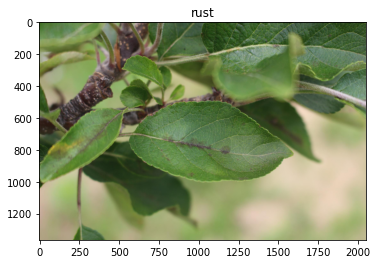

In [45]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
test_image=r'apple_split/test/scab/Train_112.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=ConvVit_xxs.predict(test_image)
print(np.argmax(result))
result1 = np.argmax(result)
# result_true()
Categories=['healthy','multiple_disease','rust','scab']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

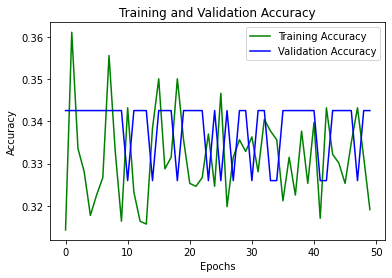

In [46]:
#plotting training and validation accuracy
import matplotlib.pyplot as plt
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(len(acc_val))
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

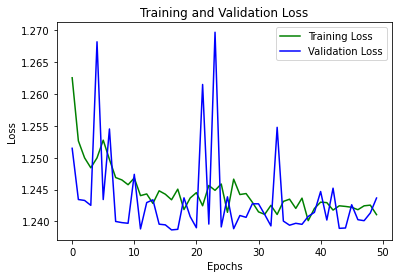

In [47]:
#plotting training and validation loss    
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(len(loss_val))
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [54]:
# Calculating accuracy_score, precision_score, recall_score, f1_score using sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

result=ConvVit_xxs.predict(test_data)
pred = np.argmax(result, axis=1)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_data.classes, pred)))

print('Precision: {:.2f}'.format(precision_score(test_data.classes, pred, average="weighted")))
print('Recall: {:.2f}'.format(recall_score(test_data.classes, pred, average="weighted")))
print('F1-score: {:.2f}\n'.format(f1_score(test_data.classes, pred, average="weighted")))


Accuracy: 0.34

Precision: 0.11
Recall: 0.34
F1-score: 0.17



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
